<font size="6">Lesson 10: Convolutional Neural Networks</font>

Readings:
- [Deep learning, section 9](http://www.deeplearningbook.org/contents/convnets.html)
- [A Comprehensive Guide to Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
- [視覚野と畳み込みニューラルネットワーク](https://lp-tech.net/articles/frQNo)
- [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [2]:
# import what you need
import warnings
warnings.filterwarnings("ignore")
from PIL import Image 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
from sklearn.metrics import accuracy_score
import torch.optim as optim

import sys
sys.path.append("/home/gonken2020/git/research/")
from implements_10.script_10 import *

--- 

<font size="5">Overview</font>
1. Introduction
1. Convolutional Neural Networks (CNN)
1. Motivation
    1. Sparse interactions
    1. Parameter sharing
    1. Equivariant representation
1. Implementation in PyTorch
1. Summary


# Introduction

--- 
In this notebook, I'm going to explain the motivations for Convolutional Neural Networks(CNN)
and its implementation.
This notebook will go through the basic understanding of CNNs, the computation procedure, and the mechanism of pooling layers.
I will start by introducing the 3 main motivations and confirm them with a simple example.
In the implementation section, I will show how to implement CNNs and compare the performance with a fully connected network (FCN).

---

# Convolutional Neural Networks (CNN)
---
A Convolutional Neural Networks is a deep learning algorithm which is generally used for image data.
It is usually composed of 3 kinds of layer; 
*convolutional layers*, *pooling layers*, and *fully connected layers* as illustrated below.
Each convolutional layer has parameters in the form of filters.
In neural networks, we call a convolutional filter the "*kernel*" and the output of each layer its "*feature map*".


\* *filter* is a tensor which we multiply with our input data through the convolution operation

<img src="implements_10/overview.png" width="800">

- this image is from [this article](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

---
Computation of the convolutional layer is a little bit tricky.
As you can see in the figure below, convolution consists of element-wise multiplication and sum of between the filter and equally sized sub-tensors from the input.


<img src="implements_10/computation.png" width="500">

Let's take a look at the video/gif of computation [here](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

---

# Motivations
---
**Sparse interactions**, **parameter sharing** and **equivariant representations** are 
characteristics of the CNN which are important for the machine learning model to learn efficiently.

---

## Sparse interactions 
---
Whereas every output unit in the fully connected layer interacts with every input unit in the next layer, 
in convolutional networks the previous layer interacts only with spacially neighboring neurons. 
These interactions occur by means of the filters. This is called **sparse interactions** as illustrated in the first image below.
This phenomenon forces each filter to focus on small features such as edges in the image.

<img src="implements_10/connectivity.jpg" width="500">

- this image is from [this article](https://www.researchgate.net/publication/318009713_Super-Resolution_via_Deep_Learning/figures)

---

This raises an interesting question--if it is made up of local connections, how is a CNN able to detect the whole picture rather than just local features?
The answer is by **making the model deeper**.
As you can see the image below, the range of interaction of units in the deeper layer might interact *indirectly*--through intermediate layers--with a large number of units, much larger than
the filter size.

The units can interact with in previous layers is called its **receptive field**.

This way, a CNN can perceive the same things a FCN would while requiring much fewer parameters.

<img src="implements_10/receptive_field.jpg" width="500">

- this image is from [this article](https://www.researchgate.net/publication/316950618_Maritime_Semantic_Labeling_of_Optical_Remote_Sensing_Images_with_Multi-Scale_Fully_Convolutional_Network/figures?lo=1)

---

## Parameter sharing
---

Parameter sharing means the model uses the same parameter more than once.
In the specific case of the convolution operation, the filter is applied to every position of the input.
This both forces the parameters to be used more efficiently due to their smaller number, and also allows convolutional layers to be location invariant.

---
Parameter sharing is very effective when you want to apply a filter to an entire picture. 
Let's look at an example of this, *edge detection*.
I have made the edge detected filter with both a convolutional layer and a fully connected layer.

---

In [17]:
resize = 64
img = Image.open("./implements_10/Minami_Hoshino.jpg").crop((132, 0, 900, 768)).resize((resize, resize))
img = img.convert("RGB")
image = transforms.ToTensor()(img).view(1, 3, resize, resize)

cl_vertical_filter = generate_edge_filter(vertical=True)
print(cl_vertical_filter)
fc_vertical_filter = generate_fc_edge_filter(vertical=True, size=resize)
print(fc_vertical_filter)

Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Linear(in_features=12288, out_features=12288, bias=True)


---

Let's see the edge of the image.

---

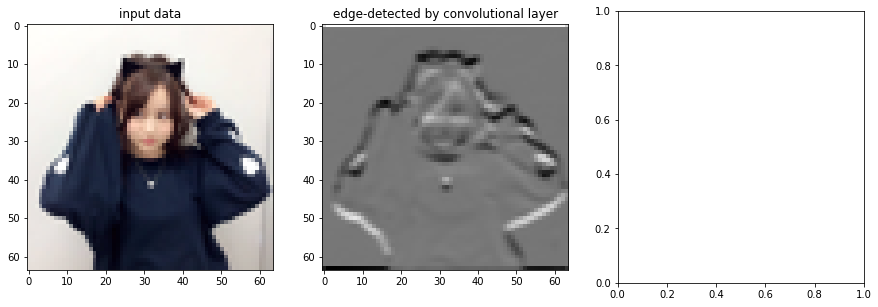

In [18]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(image_from_output(image)[0])
ax.set_title("input data")
ax = fig.add_subplot(1, 3, 2)
ax.imshow(image_from_output(cl_vertical_filter(image))[0])
ax.set_title("edge-detected by convolutional layer")
ax = fig.add_subplot(1, 3, 3)
# ax.imshow(image_from_output(fc_vertical_filter(Flatten()(image)).view(1, -1, resize, resize))[0])
# ax.set_title("edge-detected by fully connected layer")

---

Both approches are successful, so let's take a look at the parameter count.

---

In [19]:
print("")
cl_param_num = 0
for param in list(cl_vertical_filter.state_dict().keys()):
    num = cl_vertical_filter.state_dict()[param].flatten().shape[0]
    print(param, num)
    cl_param_num += num
print("whole", cl_param_num)
print("--------------------------")

fc_param_num = 0
for param in list(fc_vertical_filter.state_dict().keys()):
    num = fc_vertical_filter.state_dict()[param].flatten().shape[0]
    print(param, num)
    fc_param_num += num
print("whole", fc_param_num)


weight 81
bias 3
whole 84
--------------------------
weight 150994944
bias 12288
whole 151007232


In [20]:
f"{round(fc_param_num / cl_param_num/ 1e6, 2)} million"

'1.8 million'

---

OMG!
The fully connected edge detector has almost **2 million times** more parameters than the convolutional one.
Clearly, the convolutional layer is an extremely efficient way of describing transformations that 
apply the same computation to the entire input.

---

## Equivariant representations
---
Equivariant is the mathematical word which means that if the input changes, the output changes in the same way.
Strictly speaking, in the case of convolution, when we assume $g()$ shifts every pixel of the image, $f()$ is the computation of convolutional layer
and $I$ is the image.
$$
f(g(I)) = g(f(I))
$$
where $g(I(x,y)) = I(x+x_0, y+y_0)$.
I will give you an example of this later on.

---

# Implementation
---
Ok, so let's try to the implement Convolutional Neural Networks(CNN) in Python. In this experiment, 
we will compare the Convolutional with Fully Connected Networks by computing accuracy and checking the translational invariance.

---

## Dataset

---
At first, we will use the popular handwritten numbers dataset MNIST.
Originally, the data in this dataset has a shape of 28x28 pixels, but will resize it to 32x32.
The data is also rescaled in order to make their min and max 0 and 1 respectively.

---

In [21]:
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])

In [22]:
batch_size = 128
trainset = torchvision.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data',  train=False,  download=True,  transform=transform)
testloader = torch.utils.data.DataLoader(testset,  batch_size=len(testset), shuffle=False,  num_workers=2)

print("")
print(f"len_trainset : {len(trainset)}")
print(f"len_testset : {len(testset)}")


len_trainset : 60000
len_testset : 10000


---

These are a few samples of the data.

---

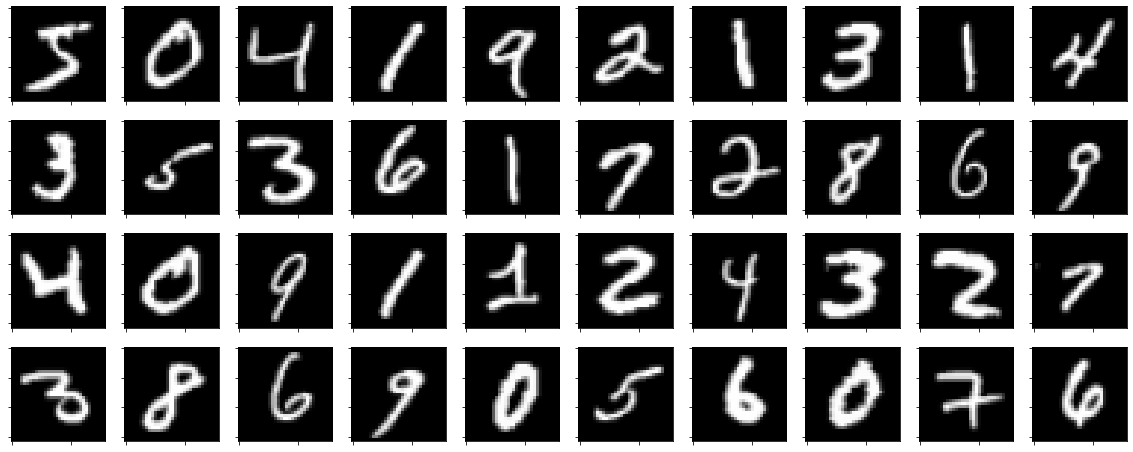

In [23]:
fig = plt.figure(figsize=(20, 8))
for i in range(40):
    image = image_from_output(trainset[i][0].view(1, 1, 32, 32))[0]
    ax = fig.add_subplot(4, 10, i+1)
    ax.imshow(image)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

## Model
---

Convolutional Neural Networks are composed of some convolutional blocks and some fully connected layers(fc),
where the convolutional block is made up of a convolutional layer, a pooling layer, and an activation fuction.
In this example, the CNN is comprised of 3 convolutional blocks and 1 fc layer.

---

As for the implementation of basic CNN, you need to set some hyperparameters as follows

- for convolutional layer
    - \# of input channels
    - \# of output channels (filters)
    - kernel size (filter size)
    - stride size
    - padding size
- for pooling layer
    - kernel size (filter size)
    - stride size
    - "max" or "average"
- for fc layer
    - input feature size
    - output feature size
    
---
    
In general, hyper-parameters in the convolutional layer are set to make the shape of its output equal to that of its input, 
and data is downsampled the pooling layer.
The output size is calculated using the expression below:
$$
\left(\left\lfloor \frac{n+2p-f}{s} \right\rfloor + 1,\quad \left\lfloor \frac{n+2p-f}{s} \right\rfloor + 1\right)
$$
where ($n$ x $n$) is the shape of input data, ($f$ x $f$) is the shape of filter, and ($s$ x $s$) is the stride.

---

In [26]:
n = 32
o = 32
f = 3
s = 1

p = (s*(o-1)+f-n)/2
p

1.0

In [27]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        layers = []
        
        layers.append(nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        layers.append(nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        layers.append(nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        layers.append(Flatten())
        layers.append(nn.Linear(in_features=64*4*4, out_features=10))
        
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

In [29]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        
        layers = []
        
        layers.append(Flatten())
        layers.append(nn.Linear(1 * 32 * 32, 120))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(120, 84))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(84, 32))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(32, 10))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [30]:
cnn = CNN()
fcn = FCN()

print("")
param_num = 0
for param in list(cnn.state_dict().keys()):
    num = cnn.state_dict()[param].flatten().shape[0]
    print(param, num)
    param_num += num
print("whole", param_num)
print("--------------------------")

param_num = 0
for param in list(fcn.state_dict().keys()):
    num = fcn.state_dict()[param].flatten().shape[0]
    print(param, num)
    param_num += num
print("whole", param_num)


layers.0.weight 36
layers.0.bias 4
layers.3.weight 576
layers.3.bias 16
layers.6.weight 9216
layers.6.bias 64
layers.10.weight 10240
layers.10.bias 10
whole 20162
--------------------------
layers.1.weight 122880
layers.1.bias 120
layers.3.weight 10080
layers.3.bias 84
layers.5.weight 2688
layers.5.bias 32
layers.7.weight 320
layers.7.bias 10
whole 136214


---

Even though they have the exact same model depth, the
FCN has over 30 times more parameters than the CNN. 

---

## Training 
---
Let's train your model !

---

### Preparation
---

For the sake of simplicity, I first implement the training and test functions.
Let's take a look.

The variables are defined as follows: 
- ***data***: this consists of images and the respective labels in the form of *(image, label)*
- ***x***: image data, shape: *(batch_size, 1, 32, 32)* 
- ***label***: the label of the image data
---

In [38]:
def do_train(net, optimizer, scheduler, criterion, trainloader, visualize=True, save=False, save_path=""):
    net.train() # make the model aware of which mode it needs to be
    losses_epoch = [] # losses respect to epoch
    for epoch in range(epoch_num):
        losses = [] 
        for itr, data in enumerate(trainloader): # get data from trainloader
            x = data[0].to(device) 
            label = data[1].to(device)

            net.zero_grad() # initialize the gradient information in the model
            y = F.softmax(net(x)) # prediction
            loss = criterion(y, label) # get the loss regarding the prediction
            loss.backward() # backpropadate through the model
            optimizer.step() # update the model

            losses.append(cuda_to_numpy(loss))
        losses_epoch.append(np.mean(np.array(losses)))
        clear_output(wait=True)
        print(epoch+1)
        if visualize:
            plt.plot(losses_epoch)
            plt.xlabel("epoch")
            plt.ylabel("loss")
            plt.show()
        scheduler.step()
    if save:
        torch.save(net.state_dict(), save_path)

In [39]:
def do_test(net, testloader):
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = F.softmax(net(images))
    return cuda_to_numpy(outputs), cuda_to_numpy(images), cuda_to_numpy(labels)

In [46]:
epoch_num = 100
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
device

'cuda'

### Convolutional Neural Networks
---
Let's define some training algorithms and begin training the CNN model we've implemented.

---

In [47]:
cnn = CNN() # call the CNN model
cnn = cnn.to(device) # use GPU or cpu
cnn.apply(weights_init) # initialize the weight
cnn_optim = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9) # call the optimizer. For now, let's use SGD.
cnn_sche = optim.lr_scheduler.ExponentialLR(cnn_optim, gamma=0.95)
criterion = nn.CrossEntropyLoss() # Loss function

---
Now we can train the model.

---

In [48]:
do_train(cnn, cnn_optim, cnn_sche, criterion, trainloader, True, False, f"./implements_10/parameters/cnn_parameters.pth")

KeyboardInterrupt: 

---
Since it's a lengthy process, I've already completed the training and saved the resulting parameters. Let's load them with the code below.

---

In [49]:
load = True
if load:
    cnn_path = f"./implements_10/parameters/cnn_parameters.pth"
    cnn_model = torch.load(cnn_path, map_location=device)
    cnn.load_state_dict(cnn_model)

---
This is the test process and the calculation of accuracy.

---

In [50]:
cnn_outputs, cnn_inputs, cnn_labels = do_test(cnn, testloader)
accuracy_score(cnn_labels, np.argmax(cnn_outputs, axis=1))

0.9902

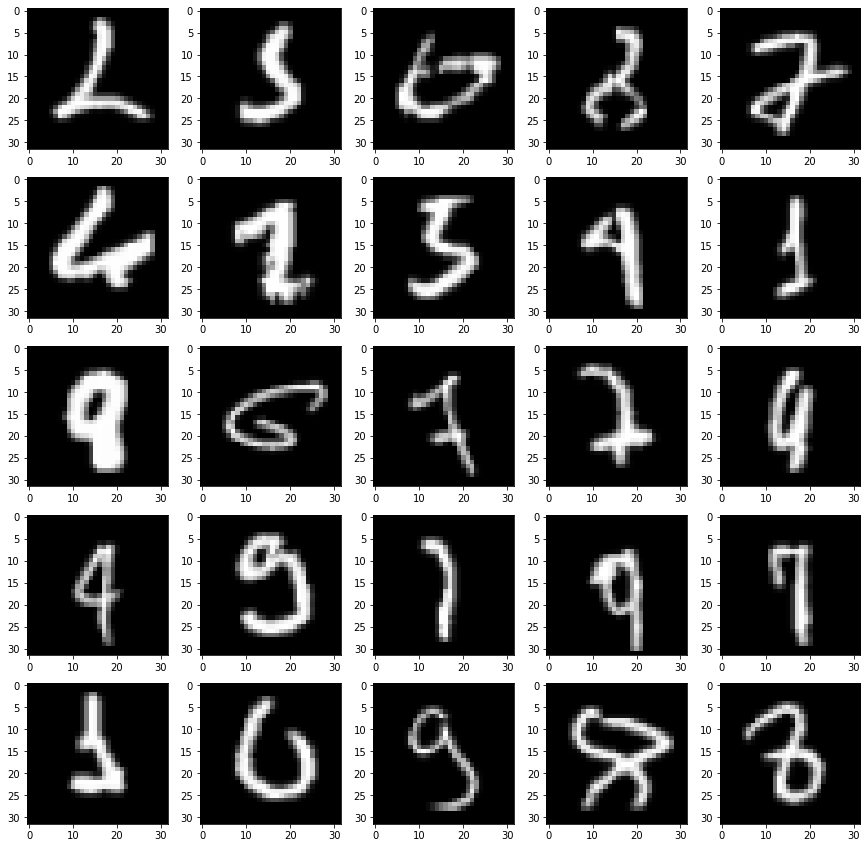

In [83]:
images = image_from_output(torch.tensor(cnn_inputs[np.argmax(cnn_outputs, axis=1) != cnn_labels]))
                           
fig = plt.figure(figsize=(15, 15))
                           
for i in range(25):
    image = images[i]
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(image)

---
Cool!

---

### Fully Connected Networks
Next, let's train the model consists of fc layers.

In [56]:
device = "cuda"

In [57]:
fcn = FCN()
fcn = fcn.to(device)
fcn.apply(weights_init)
fcn_optim = optim.SGD(fcn.parameters(), lr=0.1, momentum=0.9)
fcn_sche = optim.lr_scheduler.ExponentialLR(fcn_optim, gamma=0.95)
criterion = nn.CrossEntropyLoss()

In [ ]:
do_train(fcn, fcn_optim, fcn_sche, criterion, trainloader, True, False, f"./implements_10/parameters/fcn_parameters.pth")

In [59]:
load = True
if load:
    fcn_path = f"./implements_10/parameters/fcn_parameters.pth"
    fcn_model = torch.load(fcn_path, map_location=device)
    fcn.load_state_dict(fcn_model)

In [60]:
fcn_outputs, fcn_inputs, fcn_labels = do_test(fcn, testloader)
accuracy_score(fcn_labels, np.argmax(fcn_outputs, axis=1))

0.9802

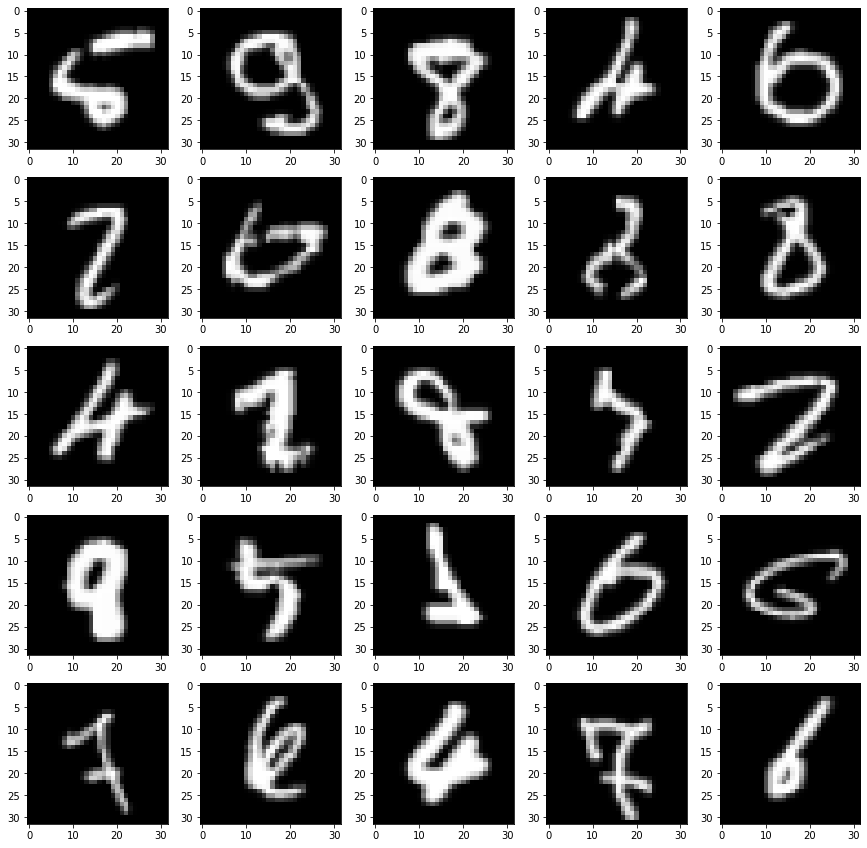

In [79]:
images = image_from_output(torch.tensor(fcn_inputs[np.argmax(fcn_outputs, axis=1) != fcn_labels]))
                           
fig = plt.figure(figsize=(15, 15))
                           
for i in range(25):
    image = images[i]
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(image)

---

Wow! This model also worked very well.

---

## Equivalent representations
---
Next, let's return to the previously mentioned topic of equivariant representations.
What will happen feature map of each layer when we shift the input image to left, right, up, or down?

---

input data


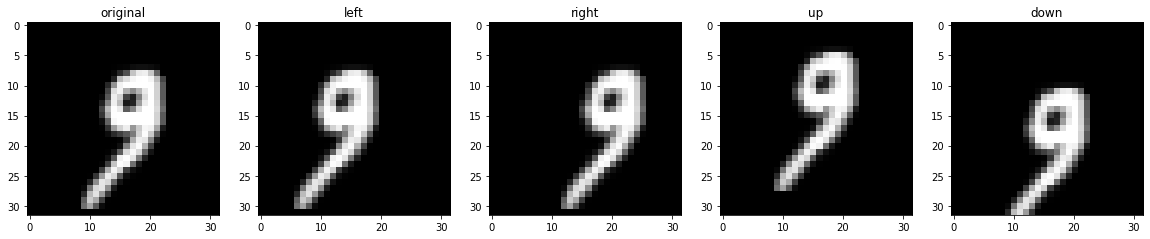

Conv2d


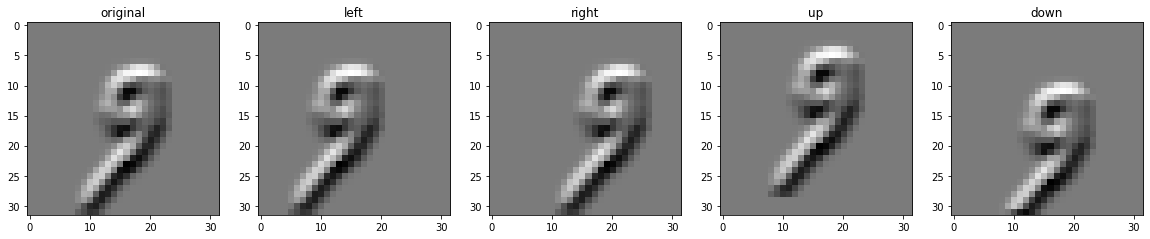

ReLU


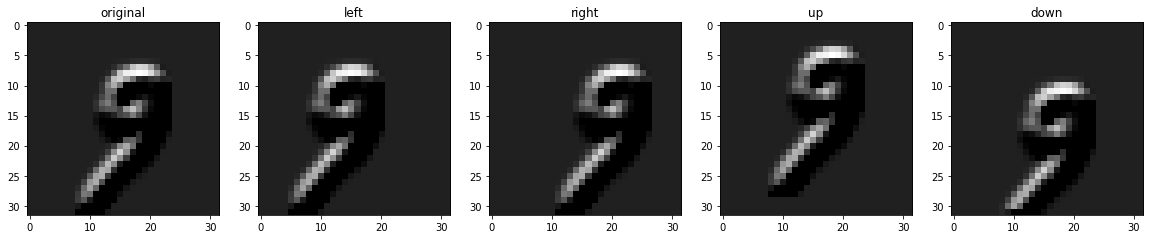

MaxPool2d


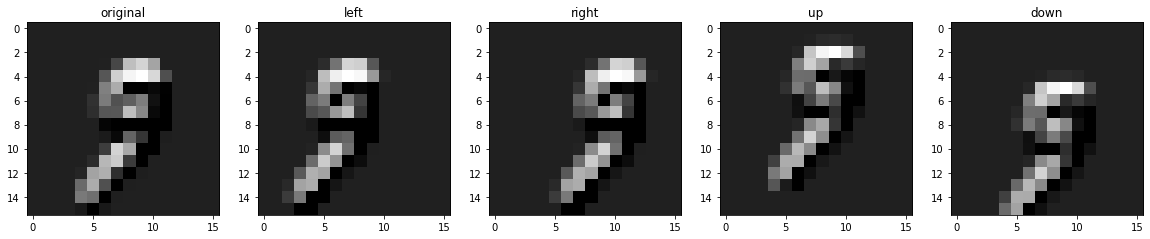

Conv2d


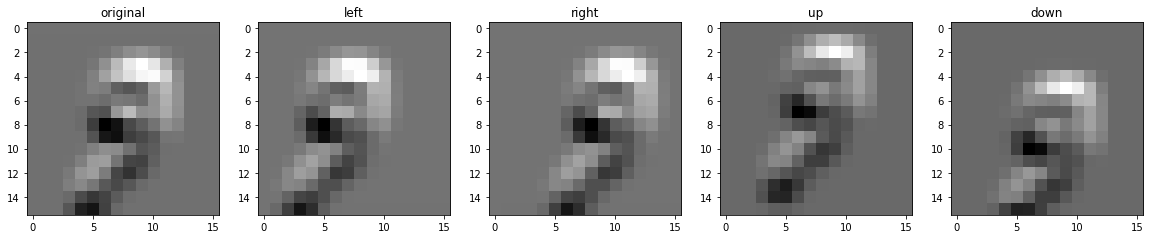

ReLU


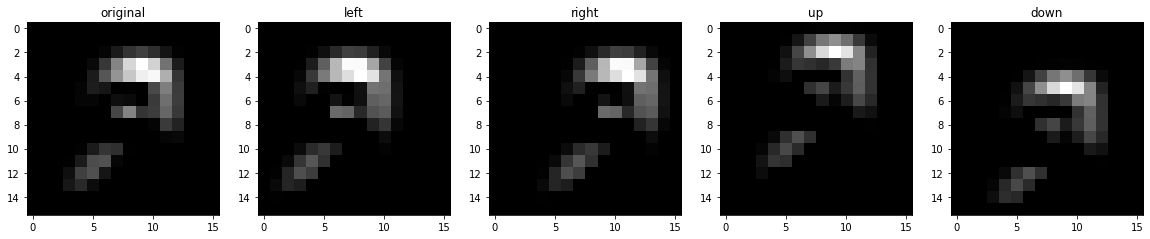

MaxPool2d


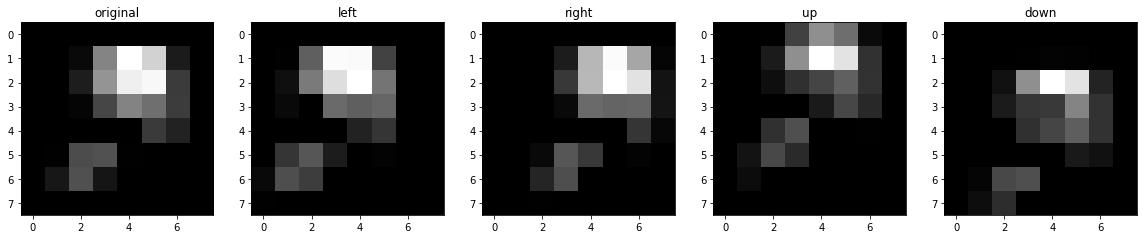

Conv2d


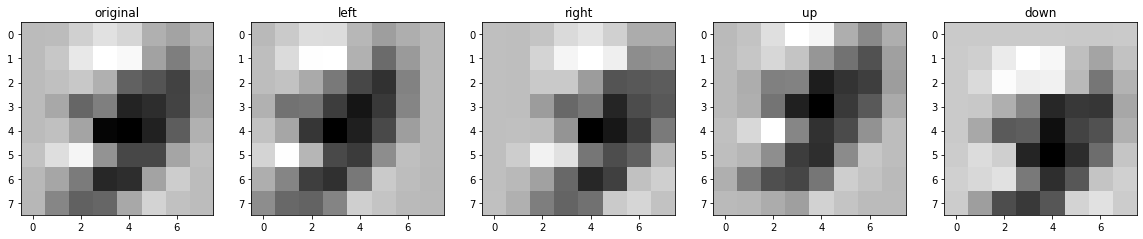

ReLU


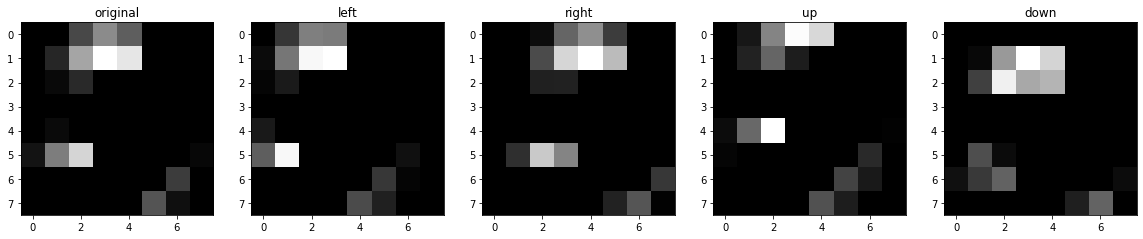

MaxPool2d


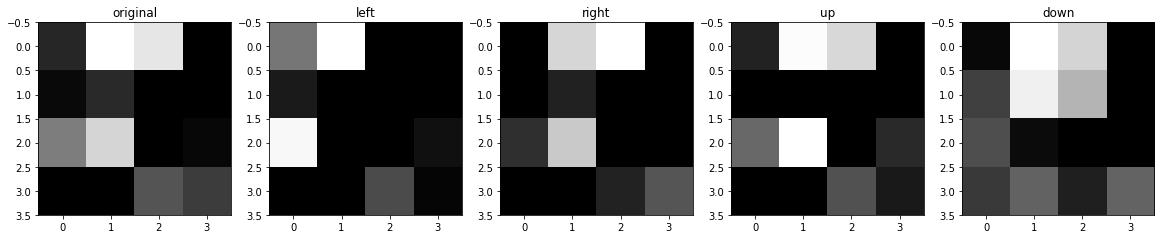

In [84]:
num = 1000
type_list = ["original", "left", "right", "up", "down"]
img = testset[num][0].view(1, 1, 32, 32)
new_list = move_image(img, transform, 3).to(device)

new = new_list
model = cnn.layers

print("input data")
fig = plt.figure(figsize=(20, 4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(image_from_output(new[i:i+1,0:1,:,:])[0])
    ax.set_title(type_list[i])
plt.show()

for layer in model[:-2]:
    print(str(layer).split("(")[0])
    fig = plt.figure(figsize=(20, 4))
    new = layer(new)

    for i in range(5):
        ax = fig.add_subplot(1, 5, i+1)
        ax.imshow(image_from_output(new[i:i+1,0:1,:,:])[0])
        ax.set_title(type_list[i])
    plt.show()

---
As you can observe, as we apply translation to the input image, the feature map suffers the same transformation.
Why do you think this is important?

---

## Translational invariance
---
Both CNN and FCN worked very well and the accuracies were almost the same.
So the reduced memory footprint the only advantage? 

***No!*** Thanks to ***sparse interactions***, ***parameter sharing***, ***equivariant representations***, and ***pooling layer***, the output of CNNs can be translationally invariant.
This is an essential feature for proper generalization in image processing. Can you see why? 

---
Let's observe the output when we shift the image to left, right, up, or down.

---

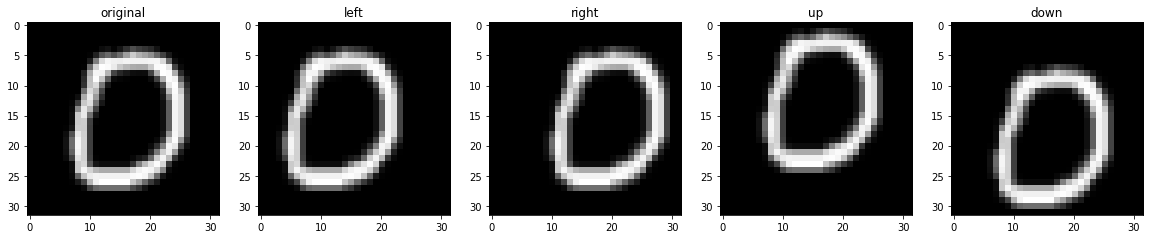

In [91]:
num = 10
type_list = ["original", "left", "right", "up", "down"]
img = testset[num][0].view(1, 1, 32, 32)
new_list = move_image(img, transform, 3).to(device)

fig = plt.figure(figsize=(20, 5))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(image_from_output(new_list[i:i+1])[0])
    ax.set_title(type_list[i])

---
Let's input them into the model we trained before.

***deviation from original data***: the absolute value of the error between the original output and the modified output.

---

CNN
    prediction                     :[0 0 0 0 0]
    deviation from original data   :0.0007467521936632693
FCN
    prediction                     :[0 2 6 6 0]
    deviation from original data   :5.988245010375977


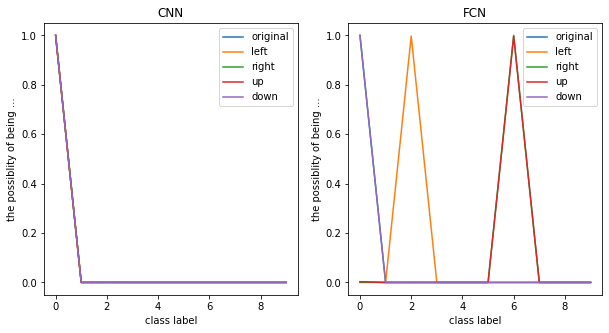

In [92]:
fig = plt.figure(figsize=(10, 5))
cnn.eval()
fcn.eval()
for j in range(2):
    model = [cnn, fcn][j]
    model_name = str(model).split("(")[0]
    print(model_name)
    ax = fig.add_subplot(1, 2, j+1)
    a = cuda_to_numpy(F.softmax(model(new_list)))
#     a = cuda_to_numpy(model(new_list))
    print(f"    prediction                     :{np.argmax(a, axis=1)}")
    print(f"    deviation from original data   :{np.sum(np.abs(a[0:1] - a[1:]))}")
    for i in range(5):
        ax.plot(a[i,:], label=type_list[i])
    plt.legend()
    ax.set_title(model_name)
    ax.set_xlabel("class label")
    ax.set_ylabel("the possiblity of being ...")

---
Our results show that the outputs from the CNN are resistant to changes in the location of the image.

---

# Summary
I have demonstrated the motivations and the implementation of Convolutional Neural Networks.
It's able to train efficiently thanks to ***sparse interactions***, ***parameter sharing***,
and ***equivariant representations***.
This has been just an introduction to the basics of CNNs.
There are a lot of applications or algorithms which use it, including U-Net, VGG16, and so on.